In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
import numpy as np
import datetime
import pandas as pd
import h5py

/usr/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Start the spar context

In [4]:
sc = pyspark.SparkContext(appName="CoeGSS_healthHabits")

# Compute the prevalence curve

We save a counter for each time step and infection status reading the 
steps of the simulation in teh output file.

We map the `((processor, time, status), 1)` and we reduce summing the values.

In [5]:
#################
# Configuration #
#################

# The abs or rel path to the output file...
resultsFileName = "../data/simulation_oneSeed_Out.h5"

#################
#################

In [6]:
# Load once and for all the steps<->datetime correspondence
with h5py.File(resultsFileName, "r") as f:
    dataset = f["timeSteps"]
    timeArra = np.empty(shape=dataset.shape, dtype=dataset.dtype)
    dataset.read_direct(timeArra)

In [7]:
# Convert the array to a pandas series for dict-like access...
timedf = pd.DataFrame(timeArra)
timedf.set_index("stepNumber", drop=True, inplace=True)
timedf.date = pd.to_datetime(timedf.date)
timedf = pd.Series(index=timedf.index, data=timedf.date)
timedf.head()

stepNumber
0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: date, dtype: datetime64[ns]

In [8]:
def stepsIterator(filename):
    '''
    Here we simulate an iterator over the tables of the output file by reading them.
    
    We have to skip the `timeSteps` dataset as it does not contains the tables we want.
    
    For each level of the output file we iterate over all the group names found until our dataset is found.
    '''
    with h5py.File(filename, "r") as f:
        for processor, processorGroup in f.iteritems():
            if processor in ["timeSteps"]: continue
            for run, runGroup in processorGroup.iteritems():
                for step in runGroup.keys():
                    if step in ["parameters", "agent"]: continue
                    yield (filename, processor, run, step)

In [9]:
def flatMap_foo(vals):
    '''
    We flatten the dataset emitting the tuple containing the information we want.
    
    In this case we export the
    `(processRank, runRank, stepNumber, infectionStatus)`
    
    Note that we filter out dead agents with `if row[aliveCol] == 0` (dead code > 0).
    '''
    filename, proc, run, step = vals
    with h5py.File(filename, "r") as f:
        dataset = f[proc][run][step]["agents/agent"]
        data_arra = np.empty(dataset.shape, dtype=dataset.dtype)
        dataset.read_direct(data_arra)
        
        indexCol = dataset.dtype.names.index("infection_status")
        aliveCol = dataset.dtype.names.index("demo_status")
        return [(int(proc), int(run), int(step), row[indexCol]) for row in data_arra if row[aliveCol] == 0]
    
def map_foo(vals):
    # We already aggregate per processor...
    return (vals[1:], 1)

def reduce_foo(cumulative, current):
    # We count the number of occurrences for each agent.
    return cumulative + current

In [10]:
# Apply the map reduce function and later collect results.
res = sc.parallelize(stepsIterator(resultsFileName)).flatMap(flatMap_foo).map(map_foo).reduceByKey(reduce_foo)

In [11]:
%%time
results = res.collect()

CPU times: user 20.6 ms, sys: 1.07 ms, total: 21.7 ms
Wall time: 1min 11s


In [12]:
results[0]

((191, 102, 0), 9142)

In [13]:
# We organize the results in a dataframe where we have the column to 
# split that contains the tuple of (run, time, status).

colToSplit = "tup"
timeCol = "time"
runCol = "run"
compartmentCol = "compartment"
populationCol = "N"

results_df = pd.DataFrame(results, columns=[colToSplit, populationCol])

results_df[runCol] = results_df[colToSplit].apply(lambda v: v[0])
results_df[timeCol] = results_df[colToSplit].apply(lambda v: v[1])
results_df[compartmentCol] = results_df[colToSplit].apply(lambda v: v[2])
del results_df[colToSplit]

results_df.head()

,N,run,time,compartment
0,9142,191,102,0
1,19750,181,68,0
2,198,199,34,4
3,2657,194,78,1
4,13079,197,104,4


In [14]:
import seaborn as sns

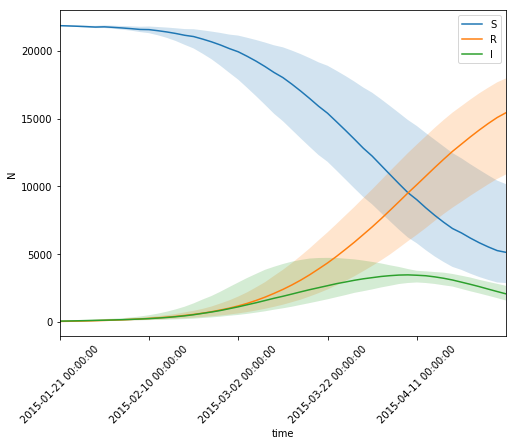

In [24]:
plt.figure(figsize=(8,6))

comp2label = {0: "S", 1: "I", 2: "A", 4: "R"}

sns.tsplot(data=results_df[results_df.time > 19], time=timeCol, unit=runCol, condition=compartmentCol, value=populationCol,\
           err_style="ci_band", ci=[0, 100])
locs, labs = plt.xticks()
locs = [l for l in locs if l < 120]
plt.xticks(locs, [timedf[loc] for loc in locs], rotation=45)

legend = plt.legend(["S", "R", "I"])

# Compute the incidence curve

We save a counter of the number of new cases for each time step, also saving
the source and context of infection.

We map the `((processor, process, timeofinfection, source, context), 1)` and
we reduce summing the values.

We proceed as before for the map reduce formalisms.

In [25]:
def stepsIterator(filename):
    with h5py.File(filename, "r") as f:
        for processor, processorGroup in f.iteritems():
            if processor in ["timeSteps"]: continue
            for run, runGroup in processorGroup.iteritems():
                last_step = -1
                for step in sorted(runGroup.keys()):
                    if step in ["parameters", "agent"]:
                        continue
                    last_step = max(int(step), last_step)
                yield (filename, processor, run, "%d" % last_step)

In [26]:
def flatMap_foo(vals):
    filename, proc, run, step = vals
    with h5py.File(filename, "r") as f:
        dataset = f[proc][run][step]["agents/agent"]
        data_arra = np.empty(dataset.shape, dtype=dataset.dtype)
        dataset.read_direct(data_arra)
        
        indexCols = [dataset.dtype.names.index(observable)\
             for observable in ["infection_source", "infection_context", "infection_time"]]
        
        return [tuple([int(proc), int(run)] + [row[i] for i in indexCols]) for row in data_arra]
    
def map_foo(vals):
    # We already aggregate per processor...
    return (vals[1:], 1)

def reduce_foo(cumulative, current):
    return cumulative + current

In [27]:
res = sc.parallelize(stepsIterator(resultsFileName)).flatMap(flatMap_foo).map(map_foo).reduceByKey(reduce_foo)

In [28]:
%%time
results_incidence = res.collect()

CPU times: user 34.2 ms, sys: 1.34 ms, total: 35.5 ms
Wall time: 1.63 s


In [29]:
results_incidence[0]

((196, 1, 1, 110), 28)

In [30]:
colToSplit = "tup"
runCol = "run"
infectSource = "infectSource"
infectContext = "infectContext"
infectTime = "infectTime"

populationCol = "N"

results_incidence_df = pd.DataFrame(results_incidence, columns=[colToSplit, populationCol])

results_incidence_df[runCol] = results_incidence_df[colToSplit].apply(lambda v: v[0])
results_incidence_df[infectSource] = results_incidence_df[colToSplit].apply(lambda v: v[1])
results_incidence_df[infectContext] = results_incidence_df[colToSplit].apply(lambda v: v[2])
results_incidence_df[infectTime] = results_incidence_df[colToSplit].apply(lambda v: v[3])
del results_incidence_df[colToSplit]

results_incidence_df.head()

,N,run,infectSource,infectContext,infectTime
0,28,196,1,1,110
1,73,180,0,2,118
2,9,200,1,2,23
3,8,191,0,2,35
4,1,200,0,0,4


In [31]:
def timeticks():
    '''
    Puts correct dates in the current xticks.
    '''
    locs, labs = plt.xticks()
    locs = [l for l in locs if 0 <= l < 120]
    plt.xticks(locs, [timedf[loc].strftime("%d/%m/%Y") for loc in locs], rotation=22.5)

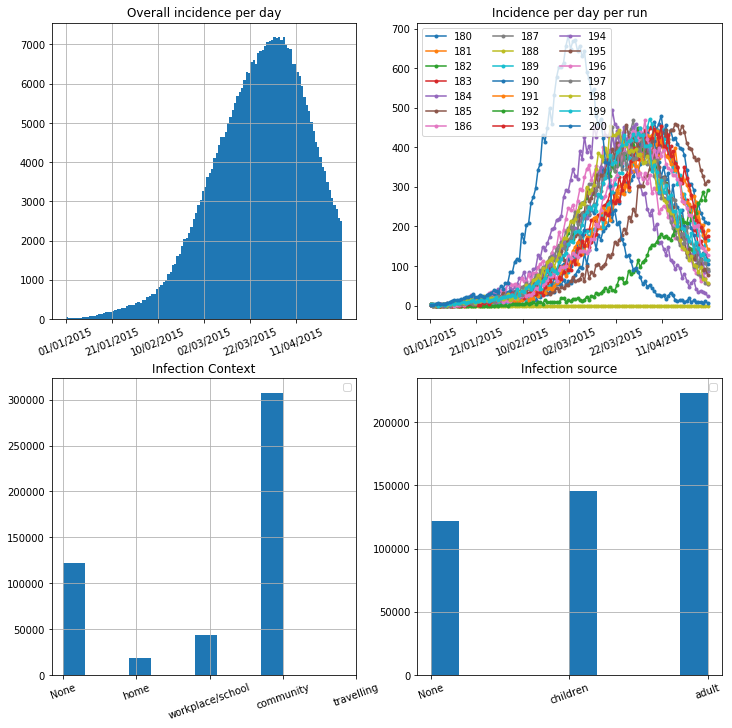

In [34]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.title("Overall incidence per day")
results_incidence_df.infectTime.hist(bins=range(0, 121), weights=results_incidence_df.N)
timeticks()


plt.subplot(2,2,2)
plt.title("Incidence per day per run")
incidence_df = None
for run, runGroup in results_incidence_df.groupby(runCol):
    y, w = runGroup[infectTime], runGroup[populationCol]
    
    f, b = np.histogram(y, weights=w, bins=np.arange(121, dtype=float), density=False)
    
    b = b[1:] + b[:-1]
    b /= 2.
    
    if incidence_df is None:
        incidence_df = pd.DataFrame(data={"time": b, run: f})
    else:
        incidence_df[run] = f
    
    plt.plot(b, f, ".-", label="%d"%run)
#sns.tsplot(data=incidence_df, time="time", unit)
timeticks()
plt.legend(ncol=3)


plt.subplot(2,2,3)
plt.title("Infection Context")
results_incidence_df.infectContext.hist(weights=results_incidence_df.N)
contexts = {-1: "None", 0: "home", 1: "workplace/school", 2: "community", 3: "travelling"}
plt.xticks(sorted(contexts.keys()), [i for k, i in sorted(contexts.items())], rotation=20)
plt.legend()

plt.subplot(2,2,4)
plt.title("Infection source")
results_incidence_df.infectSource.hist(weights=results_incidence_df.N)
sources = {-1: "None", 0: "children", 1: "adult"}
plt.xticks(sorted(sources.keys()), [i for k, i in sorted(sources.items())], rotation=20)
plt.legend()


# Stop the spark context

In [35]:
sc.stop()